# 2D exploration of Relative Humidity from NAM data

In this tutorial we will explore the NAM dataset provided by NOAA. 
In particular, we will use the daily relative humidity reanalysis data for a period of ten years (2008-10-28) to (2018-09-20). We will just use the first years worth of data for a quick assessment. The readers are encouraged to increase the number of snapshots.

## Dataset

We have provided a smaller (filtered) version of the data set based on a classical POD method. The flow field can be reconstructed with ~40 MB of data rather than the original snapshot data (3.5 GB). This data was preprocessed in a custom manner before this analysis could run. Please contact me (rmaulik@anl.gov) for access to the raw data (and for other covariates such as Temperature, Windspeeds, Pressure, etc.).

The purpose of this tutorial is to get you going with an analysis on publicly available weather data that doesn't require a heavy duty data transfer. The details of this data set are available at: 
https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-mesoscale-forecast-system-nam

## Loading and configuring data

Now we import some basic libraries that can be used to reconstruct our data set and set a seed (the latter because its good practice)

In [6]:
import numpy as np
np.random.seed(10)

pod_modes = np.load('RH_P0_L4_GLC0_Modes.npy')
pod_coefficients = np.load('RH_P0_L4_GLC0_Coefficients.npy')

snapshots = np.matmul(pod_modes,pod_coefficients).reshape(428,614,3569)
snapshots = np.rollaxis(snapshots,-1,0)
snapshots = snapshots.reshape(-1,428,614,1)[:356] # increase the slice to grab a larger dataset

Lets visualize a sample of the data - you can see the faint outline of the U.S. West Coast here. Unfortunately, we don't have a coastal outline available for this data set yet but we will add this later.

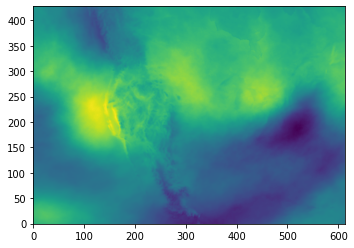

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(snapshots[0,:,:,0],origin='lower')
plt.show()

Once we have imported our data, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 

    - `from pyspod.spod_low_storage import SPOD_low_storage`
    - `from pyspod.spod_low_ram     import SPOD_low_ram`
    - `from pyspod.spod_streaming   import SPOD_streaming`

that include three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 

    - `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [8]:
import os
import sys
import time
import warnings

# Current path
CWD = os.getcwd()

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.utils_weights as utils_weights

Lets inspect some shapes of our data and retrieve them so PySPOD can use them

In [9]:
print('shape of t (time): ', snapshots.shape[0])
print('shape of x1 (latitude): ', snapshots.shape[1])
print('shape of x2 (longitude) : ', snapshots.shape[2])

lat = np.arange(snapshots.shape[1])
lon = np.arange(snapshots.shape[2])
variables = ['RH']

shape of t (time):  356
shape of x1 (latitude):  428
shape of x2 (longitude) :  614


The data is already in a format that PySPOD can interface with so we can directly move to analyses. Note that we do not have latitude and longitude information - so we basically just visualize on a structured grid

## Settings required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_DFT`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data


<font color='green'> **Note: we used the built-in module `utils_weights`, and in particular the function `utils_weights.geo_trapz_2d` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights into the `custom` function inside `utils_weights.py` or by readily providing the weights as a numpy.ndarray. The weights must have a shape equal to the data spatial dimensions $\times$ number of variables, that is:**
    
$$\textsf{weights dim} = \textsf{spatial shape} \times \textsf{number of variables} = 428 \times 614 \times 1 $$. </font>

In [10]:
# define required and optional parameters
params = dict()

# -- required parameters
params['time_step'   ] = 1                	# data time-sampling (1 day)
params['n_snapshots' ] = snapshots.shape[0] # number of time snapshots (we consider all data)
params['n_space_dims'] = 2                	# number of spatial dimensions (longitude and latitude)
params['n_variables' ] = 1            		# number of variables
params['n_DFT'       ] = np.ceil(3 * 30)    # length of FFT blocks (30 days by 4 months)

# -- optional parameters
params['overlap'          ] = 0 			# dimension block overlap region in percentage [0, 100]
params['mean_type'   	  ] = 'blockwise' 	# type of mean to subtract to the data
params['normalize_weights'] = True        	# normalization of weights by data variance
params['normalize_data'   ] = False  		# normalize data by data variance
params['n_modes_save'     ] = 3      		# modes to be saved
params['conf_level'       ] = 0.95   		# calculate confidence level
params['reuse_blocks'     ] = False 		# whether to reuse blocks if present
params['savefft'          ] = False  		# save FFT blocks to reuse them in the future (saves time)
params['savedir'          ] = os.path.join(CWD, 'results/NAM_2D/') # folder where to save results

# Set weights
weights = utils_weights.geo_trapz_2D(
	x1_dim=lon.shape[0], x2_dim=lat.shape[0],
	n_vars=len(variables), R=1)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_ram(data=ds, params=params, data_handler=read_data, variables=variables)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or the function data reader (i.e. the `read_data` we defined earlier) and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. 
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 
  - `weights`: is a np.ndarray of shape = spatial dimensions $\times$ number of variables = 428 $\times$ 614 $\times$ 1


The `fit()` method returns a `PySPOD` object containg the results. 

**NOTE: we use the low ram version of the library, as the dataset is relatively large. (The next step may take a while)**

In [11]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_storage(
	data=snapshots,
	params=params,
	data_handler=False,
	variables=variables,
	weights=weights)

# Fit SPOD
spod = SPOD_analysis.fit()


Normalization by variance
-------------------------
variable =  0 ,  variance =  406.81863

SPOD parameters
------------------------------------
Problem size               :  0.6970312595367443 GB. (double)
No. of snapshots per block :  90
Block overlap              :  0
No. of blocks              :  3
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  geo_trapz_2D
Mean                       :  blockwise
Number of frequencies      :  46
Time-step                  :  1
Time snapshots             :  356
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  True
Normalization data         :  False
Number of modes to be saved:  3
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/NAM_2D/results/NAM_2D/
Save FFT blocks            :  False
Reuse FFT blocks           :  False
Spectrum type             :  one-sided (real-valued signal)
------------------------------------


computing frequencies:   0%|          | 0/46 [00:00<?, ?it/s]

block 3/3 (180:270)
--------------------------------------
 
Calculating SPOD (low_storage)
--------------------------------------


computing frequencies: 100%|██████████| 46/46 [00:01<00:00, 35.96it/s]


--------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/NAM_2D/results/NAM_2D/nfft90_novlp0_nblks3
Elapsed time:  4.137699842453003 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` object that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [12]:
# Show results
T_approx = 30 # approximate period = 30 days (1 month)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

- RAM required for loading all modes ~ 0.07048630714416515 GB
- Available RAM memory               ~ 16.32743072509768 GB


We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

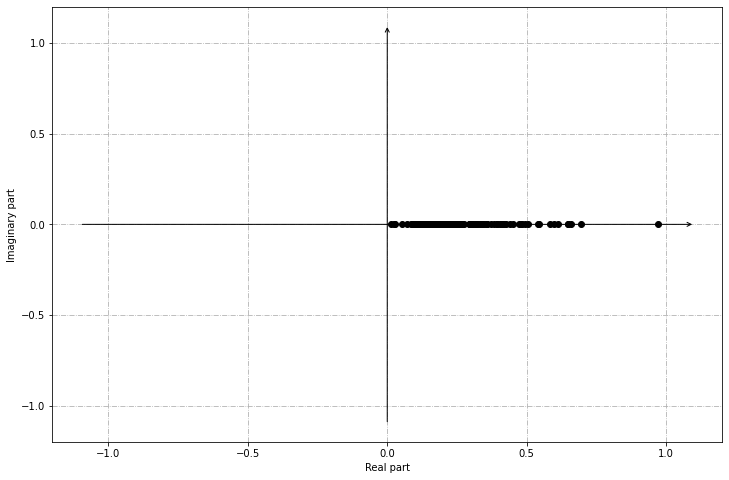

In [13]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 7, that is the factor going from 1 days of time-step to 1 week, so that we obtain a period for the x-axis in 1-week increments). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

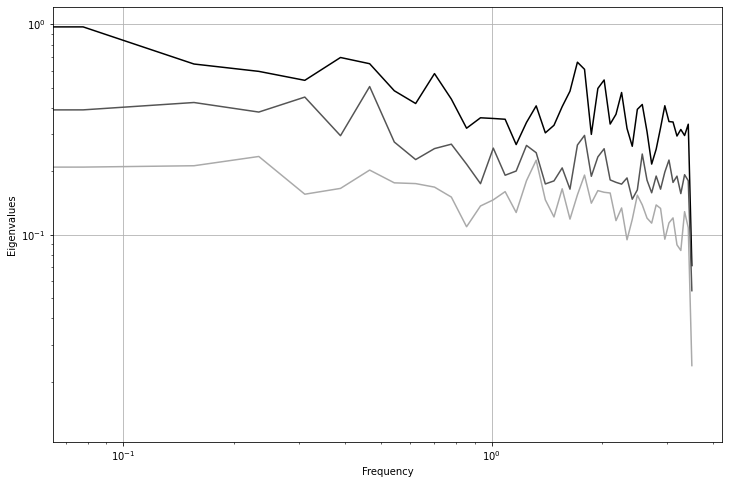

In [14]:
freq = spod.freq * 7 # (in weeks)
spod.plot_eigs_vs_frequency(freq=freq)

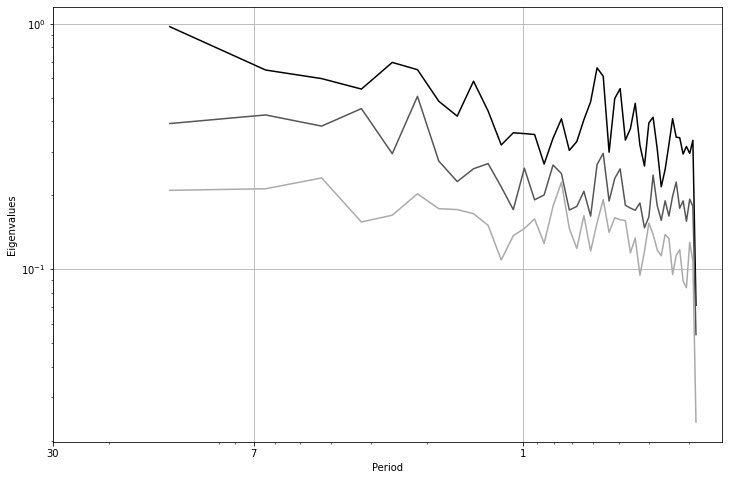

In [15]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 30 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. 

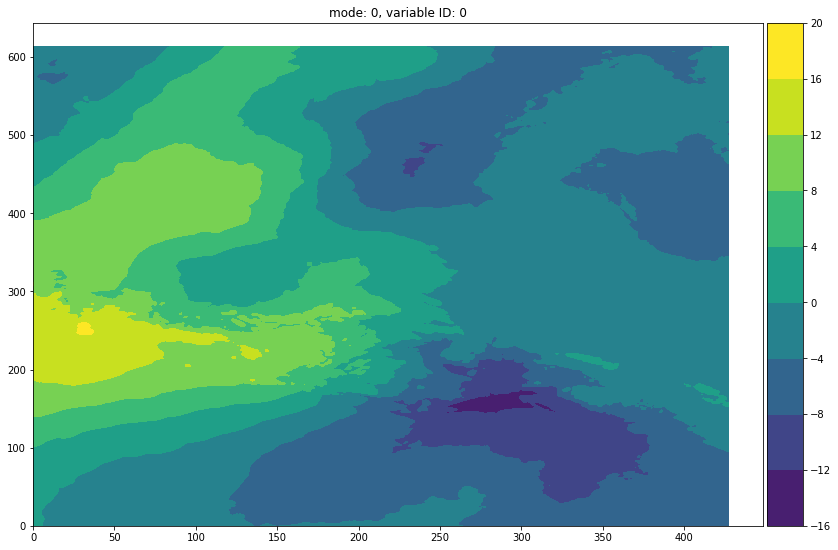

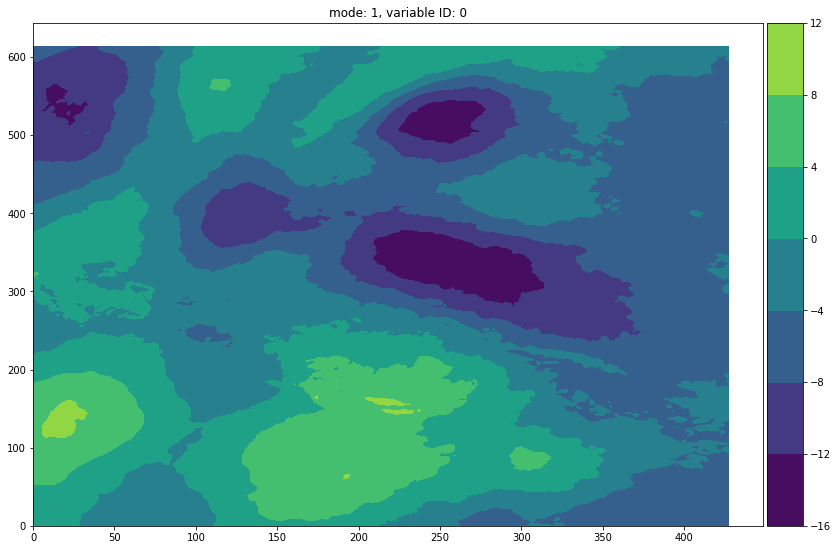

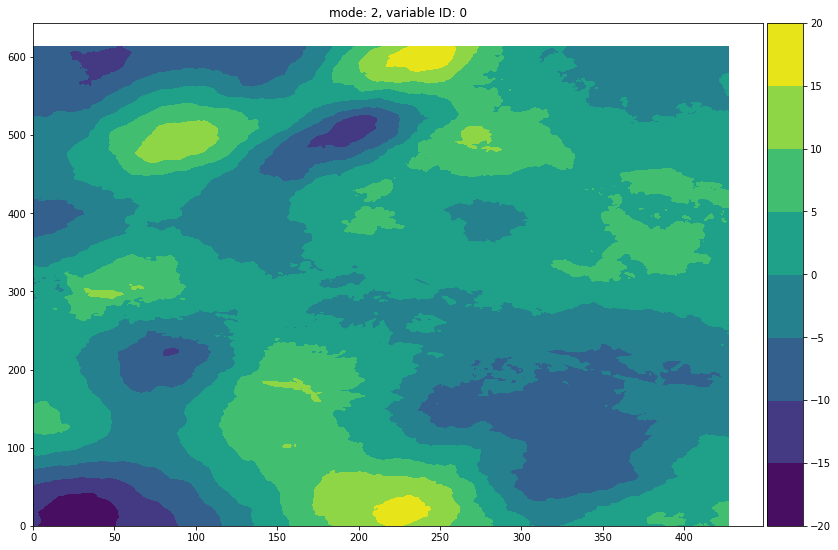

In [16]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=lat, x2=lon, modes_idx=[0,1,2], vars_idx=[0], origin='lower')

Note that we can also plot the **original data** by

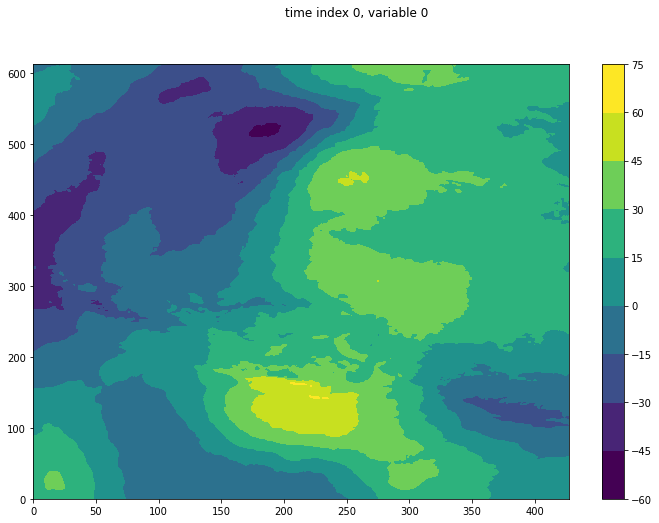

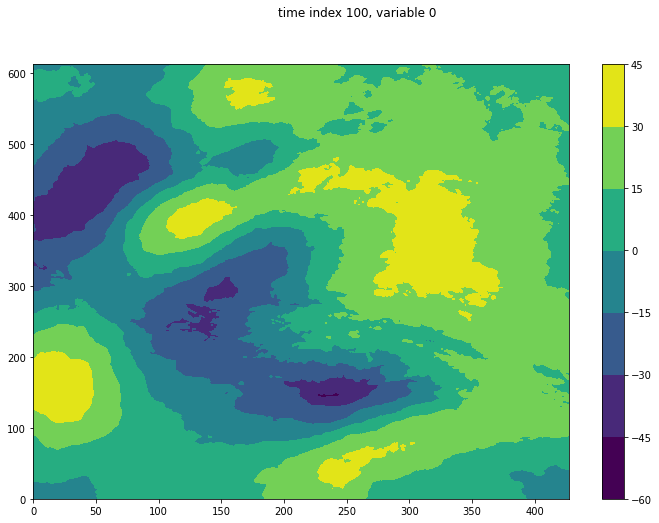

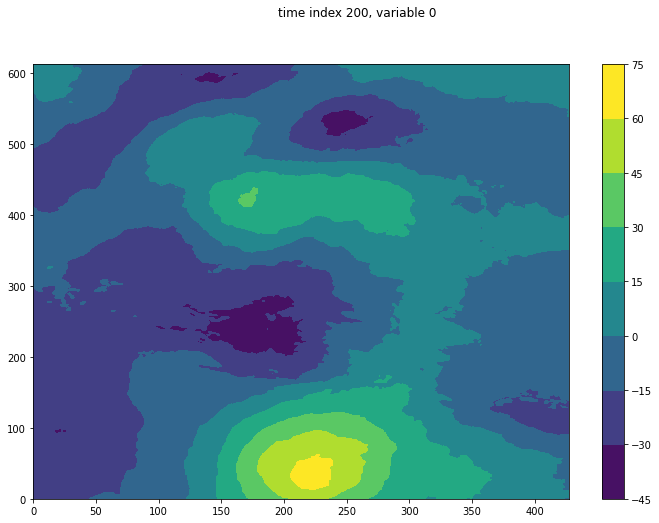

In [17]:
spod.plot_2D_data(x1=lat, x2=lon, vars_idx=[0], time_idx=[0,100,200],origin='lower')

Along with a video of the original data

In [18]:
spod.generate_2D_data_video(x1=lat, x2=lon, vars_idx=[0])

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_storage(data=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(data=X, params=params, file_handler=False)

and compare the results.